# Voting System using NSL-KDDD dataset for SIEM/IDS systems

It's a system that combines three indepedant neural networks and fuses their output according to a voting system which follows the majority-rules process!

## Preparing Environement

In [ ]:
import numpy as np
import pandas as pd

## label encoder
from sklearn.preprocessing import LabelEncoder

## for plotting
import matplotlib.pyplot as plt

Next, we will load the different of the dataset and the indices of the nominal and numerical features in the training/test set.

In [ ]:
train_nsl_kdd_dataset_path = "/content/drive/My Drive/Colab Notebooks/NSL_KDD_Dataset/KDDTrain+.txt"
test_nsl_kdd_dataset_path = "/content/drive/My Drive/Colab Notebooks/NSL_KDD_Dataset/KDDTest+.txt"

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()


Whether we will be using binary classification or multi-class classification, we will need a a dictionnary that will map the output

In [ ]:
# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',

    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',

    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',

    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}


## Data manipulation

In [ ]:
import torch
import torch.utils.data
cols = list(range(0, 42))
train = pd.read_csv(train_nsl_kdd_dataset_path, sep=",", names = col_names, usecols = cols)
test = pd.read_csv(test_nsl_kdd_dataset_path, sep=",", names = col_names, usecols = cols)

# Splitting Data into train and validation (80% Training and 20% Validation)
train_size = int(0.8 * len(train))
validation_size = len(train) - train_size
Training_Set, Validation_Set = torch.utils.data.random_split(train, [train_size, validation_size])

# Train data
Y_train  = pd.DataFrame(Training_Set.dataset.iloc[Training_Set.indices]['labels'])
X_train = Training_Set.dataset.iloc[Training_Set.indices].drop(columns="labels")

# Validation data
Y_val  = pd.DataFrame(Validation_Set.dataset.iloc[Validation_Set.indices]['labels'])
X_val = Validation_Set.dataset.iloc[Validation_Set.indices].drop(columns="labels")

# Test data
Y_test  = pd.DataFrame(test['labels'])
X_test = test.drop(columns="labels")

print("Shape of X_train is ", X_train.shape, "shape of target", Y_train.shape)
print("Shape of X_val is ", X_val.shape, "shape of target", Y_val.shape)
print("Shape of X_test is ", X_test.shape, "shape of target", Y_test.shape)

Shape of X_train is  (100778, 41) shape of target (100778, 1)
Shape of X_val is  (25195, 41) shape of target (25195, 1)
Shape of X_test is  (22544, 41) shape of target (22544, 1)


In [ ]:
X_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
105385,0,tcp,http,SF,295,1215,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,16,0.0,0.0,0.0,0.0,1.0,0.0,0.12,162,255,1.00,0.00,0.01,0.01,0.00,0.0,0.00,0.0
83300,0,tcp,ftp_data,SF,1109,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,160,58,0.19,0.03,0.19,0.03,0.00,0.0,0.00,0.0
113207,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,228,228,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,209,0.82,0.02,0.82,0.00,0.00,0.0,0.12,0.0
33036,0,udp,domain_u,SF,55,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,64,81,0.72,0.03,0.72,0.02,0.02,0.0,0.22,0.0
31107,0,udp,private,SF,28,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,80,0.0,0.0,0.0,0.0,1.0,0.0,0.00,152,80,0.53,0.03,0.53,0.00,0.00,0.0,0.00,0.0


In [ ]:
X_train['flag'].value_counts()

SF        59950
S0        27846
REJ        9029
RSTR       1924
RSTO       1258
S1          292
SH          219
S2          101
RSTOS0       80
S3           40
OTH          39
Name: flag, dtype: int64

Now, we will create to types of fata for Binary classification and Multi-class classification

In [ ]:
# 5 Classes dataset

Y_train5 = Y_train.copy()
Y_train5['labels'] = Y_train5['labels'].map(attack_dict)

Y_val5 = Y_val.copy()
Y_val5['labels'] = Y_val5['labels'].map(attack_dict)

Y_test5 = Y_test.copy()
Y_test5['labels'] = Y_test5['labels'].map(attack_dict)

In [ ]:
Y_test5.head()

,labels
0,DoS
1,DoS
2,normal
3,Probe
4,Probe


In [ ]:
# 2 Classes dataset

import re

Y_train2 = Y_train.copy()
Y_train2['labels'] = Y_train2['labels'].map({v : re.sub('^(?!normal).*$', 'attack', k) for  v, k in attack_dict.items()})

Y_val2 = Y_val.copy()
Y_val2['labels'] = Y_val2['labels'].map({v : re.sub('^(?!normal).*$', 'attack', k) for  v, k in attack_dict.items()})

Y_test2 = Y_test.copy()
Y_test2['labels'] = Y_test2['labels'].map({v : re.sub('^(?!normal).*$', 'attack', k) for  v, k in attack_dict.items()})

In [ ]:
Y_test2.head()

,labels
0,attack
1,attack
2,normal
3,attack
4,attack


In [ ]:
#Y_train5['labels'].value_counts()
#Y_test5['labels'].value_counts()

#Y_train2['labels'].value_counts()
Y_test2['labels'].value_counts()

attack    12833
normal     9711
Name: labels, dtype: int64

## Feature Selection & Feature Encoding & Normalization

First we will remove the features removed in some article

In [ ]:
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()
X_test_copy = X_test.copy()

In [ ]:
#index_keep = [2, 4, 5, 11, 22, 23, 24, 27, 30, 31, 32, 34]

#remove_indices = []
#for x in range(40):
#  if (x not in index_keep):
#    remove_indices.append(x)
remove_indices = [7, 8, 9, 11, 14, 15, 17, 19, 20, 21, 32, 40]
print("Indices to remove: ", remove_indices)

cols_to_remove = col_names[remove_indices].tolist()

X_train_remove = X_train_copy.drop(columns = cols_to_remove)
X_val_remove = X_val_copy.drop(columns = cols_to_remove)
X_test_remove = X_test_copy.drop(columns = cols_to_remove)

features = [i for j, i in enumerate(col_names) if j not in remove_indices]
features.pop()

Indices to remove:  [7, 8, 9, 11, 14, 15, 17, 19, 20, 21, 32, 40]


'labels'

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# Encode the data

ct_new = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), nominal_cols),
], remainder='passthrough')

X_train_papers = pd.DataFrame((ct_new.fit_transform(X_train_remove)).toarray())
X_val_papers = pd.DataFrame((ct_new.transform(X_val_remove)).toarray())
X_test_papers = pd.DataFrame((ct_new.transform(X_test_remove)).toarray())

In [ ]:
# And then we normalize the data 

scalerr = preprocessing.StandardScaler().fit(X_train_papers)

X_train_scaled = scalerr.transform(X_train_papers)
X_val_scaled = scalerr.transform(X_val_papers)
X_test_scaled = scalerr.transform(X_test_papers)

print("Done !")

Done !


In [ ]:
X_train_scaled.shape

(100778, 109)

In [ ]:
, #!pip install tensorflow Boruta

#import pandas as pd
#from sklearn.ensemble import RandomForestClassifier
#from boruta import BorutaPy

# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
#y = Y_train2.to_numpy().ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
#feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=16)

# find all relevant features - 5 features should be selected
#feat_selector.fit(X_train_scaled, y)

# check selected features - first 5 features are selected
#feat_selector.support_

# check ranking of features
#feat_selector.ranking_

# call transform() on X to filter it down to selected features
#X_train_boruta = feat_selector.transform(X_train_scaled)
#X_val_boruta = feat_selector.transform(X_val_scaled)
#X_test_boruta = feat_selector.transform(X_test_scaled)

('#!pip', 'install', 'tensorflow', 'Boruta')

## PCA

In [ ]:
from sklearn.decomposition import PCA

# We apply PCA data after feature extraction

my_PCA = PCA(n_components=90) # 99% Variance retained
my_PCA.fit(X_train_scaled)

X_train_PCA = my_PCA.transform(X_train_scaled) 
X_val_PCA = my_PCA.transform(X_val_scaled) 
X_test_PCA = my_PCA.transform(X_test_scaled) 

#print(my_PCA.explained_variance_)
#print(my_PCA.explained_variance_ratio_)
print(my_PCA.explained_variance_ratio_.cumsum())
("Done !", X_train_PCA.shape)

[0.08002966 0.12681414 0.15968486 0.18640701 0.20650384 0.22513801
 0.24074832 0.2548583  0.26788895 0.27928882 0.29018296 0.30097618
 0.31170075 0.32224512 0.3326961  0.34301534 0.35276842 0.36232579
 0.37176109 0.38111812 0.39045657 0.39973862 0.40901626 0.41826022
 0.42749935 0.4367337  0.44596146 0.45518777 0.46441359 0.47363816
 0.48286104 0.49208156 0.50130088 0.51051899 0.51973657 0.52895204
 0.53816733 0.54738126 0.55659432 0.56580624 0.57501754 0.58422831
 0.59343803 0.60264756 0.61185624 0.62106404 0.6302716  0.63947877
 0.64868522 0.65789129 0.66709574 0.67629966 0.68550268 0.69470394
 0.70390443 0.71310383 0.72230219 0.7314999  0.74069294 0.74987816
 0.75906219 0.76824299 0.77742323 0.78660309 0.79577987 0.80495593
 0.81413154 0.82330663 0.8324815  0.841656   0.8508302  0.86000288
 0.86916997 0.878317   0.88743721 0.89647383 0.90547278 0.91424465
 0.92259725 0.93078023 0.93840697 0.94569563 0.95198907 0.95808482
 0.96353957 0.96839102 0.97320684 0.9774537  0.98135633 0.9848

('Done !', (100778, 90))

Now we prepare labels for binary and multi-class classification

In [ ]:
# Binary Classification

ct_2 = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), ['labels']),
], remainder='passthrough')

#Y_train2 = pd.DataFrame(ct_2.fit_transform(Y_train2), columns = ct_2.get_feature_names())
#Y_test2 = pd.DataFrame(ct_2.transform(Y_test2), columns = ct_2.get_feature_names())

Y_train2 = Y_train2.replace('normal', 0)
Y_train2 = Y_train2.replace('attack', 1)

Y_val2 = Y_val2.replace('normal', 0)
Y_val2 = Y_val2.replace('attack', 1)

Y_test2 = Y_test2.replace('normal', 0)
Y_test2 = Y_test2.replace('attack', 1)

# Multi-class Classification

ct_5 = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), ['labels']),
], remainder='passthrough')

Y_train5 = pd.DataFrame(ct_5.fit_transform(Y_train5).toarray(), columns = ct_5.get_feature_names())

Y_val5 = pd.DataFrame(ct_5.fit_transform(Y_val5).toarray(), columns = ct_5.get_feature_names())

Y_test5 = pd.DataFrame(ct_5.transform(Y_test5).toarray(), columns = ct_5.get_feature_names())

print("Done !")

Done !


# Neural Networks / Base learners

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Hyper-parameters of the first neural network
data_size, input_size = X_train_PCA.shape
num_classes = 1
num_epochs = 15

remove_percentage = 0.67

# convert the data arrays into torch tensors
Xtrain_PCA = torch.from_numpy(X_train_PCA).float()
Ytrain = torch.from_numpy(Y_train2.to_numpy()).float()

Xval_PCA = torch.from_numpy(X_val_PCA).float()
Yval = torch.from_numpy(Y_val2.to_numpy()).float()

Xtest_PCA = torch.from_numpy(X_test_PCA).float()
Ytest = torch.from_numpy(Y_test2.to_numpy()).float()

Define the first neural network

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, remove_percentage, order):
        super(NeuralNet, self).__init__()
        self.order = order
        self.fc1 = torch.nn.Linear(input_size, hidden_size) 
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)  
        self.log_soft = torch.nn.Sigmoid()
        
    def forward(self, x):
        if self.training:
            out = self.train_module(x, self.order)
            out = self.fc1(out)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.log_soft(out)
        else:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.log_soft(out)
        return out
    
    def train_module(self, input_data, order):
        # This function will remove remove_percentage % of features
        # Order is the rank of features to remove
        out = input_data.clone()
        
        keep_percentage = round(1 - remove_percentage, 2)
        removing_step = round(input_size * keep_percentage)
            
        for i in range(input_size):
            if i in range((order - 1) * removing_step, order * removing_step):
                out[:, i] /= keep_percentage
            else:
                out[:, i] = 0.0
        return out

seed_value = 10 # some number that you manually pick
torch.manual_seed(seed_value)

In [ ]:
from torch.autograd import Variable

# define the training procedure
# i.e. one step of gradient descent
# there are lots of steps
# so we encapsulate it in a function
# Note: inputs and labels are torch tensors

def train(model, criterion, optimizer, inputs, labels):
    
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)
    
    model.train()
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# similar to train() but not doing the backprop step
def get_cost(model, criterion, inputs, labels):
    
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    model.eval()
    # Forward
    outputs = model(inputs)
    loss = criterion(outputs, labels)
     
    return loss.item()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# define the prediction procedure
def predict(model, inputs):
    
    model.eval()
    prediction = model(inputs)
    prediction = (prediction > 0.5)
    
    return prediction

# return the accuracy
def my_score(model, inputs, labels):
    prediction = predict(model, inputs)
    return (classification_report(labels, prediction, target_names=['Normal', 'Attack']))

# return the full performance metrics
def get_accuracy(model, inputs, labels):
    prediction = predict(model, inputs)
    return accuracy_score(labels, prediction)

In [ ]:
order = 1 # The first 30 features will be keeped
hidden_size = 10
model1 = NeuralNet(input_size, hidden_size, num_classes, remove_percentage, order)



# Loss and optimizer
criterion1 = torch.nn.BCELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr= 0.003)


# Use a DataLoader to manage batches
bs = 256 # batch size
train_ds = TensorDataset(Xtrain_PCA, Ytrain)
valid_ds = TensorDataset(Xval_PCA, Yval)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)



# things to keep track of
train_costs = []
validation_costs = []
train_accuracies = []
validation_accuracies = []

print("Training the first neural network...")

# main training loop
for i in range(num_epochs): # Number of epochs
    cost = 0
    val_cost = 0
    for xb,yb in train_dl:
        cost += train(model1, criterion1, optimizer1, xb, yb)
        
    train_acc = get_accuracy(model1, Xtrain_PCA, Ytrain)
    val_acc = get_accuracy(model1, Xval_PCA, Yval) 
    val_cost = get_cost(model1, criterion1, Xval_PCA, Yval)
    test_acc = get_accuracy(model1, Xtest_PCA, Ytest) 

    print("Epoch: %d, val_cost: %f, val_acc: %.4f, test_acc: %.4f" % (i, val_cost, val_acc, test_acc))
    
    # for plotting
    train_costs.append(cost / len(train_dl))
    train_accuracies.append(train_acc)
    validation_costs.append(val_cost)
    validation_accuracies.append(val_acc)
#    if (round(val_cost, 3) <= 0.3):
#      break
print("Training is done")

Training the first neural network...
Epoch: 0, val_cost: 0.459552, val_acc: 0.9213, test_acc: 0.7652
Epoch: 1, val_cost: 0.358524, val_acc: 0.9453, test_acc: 0.7560
Epoch: 2, val_cost: 0.318044, val_acc: 0.9495, test_acc: 0.7480
Epoch: 3, val_cost: 0.296283, val_acc: 0.9528, test_acc: 0.7425
Epoch: 4, val_cost: 0.282477, val_acc: 0.9573, test_acc: 0.7405
Epoch: 5, val_cost: 0.272478, val_acc: 0.9594, test_acc: 0.7390
Epoch: 6, val_cost: 0.264995, val_acc: 0.9608, test_acc: 0.7382
Epoch: 7, val_cost: 0.258708, val_acc: 0.9619, test_acc: 0.7375
Epoch: 8, val_cost: 0.253728, val_acc: 0.9628, test_acc: 0.7375
Epoch: 9, val_cost: 0.249622, val_acc: 0.9637, test_acc: 0.7361
Epoch: 10, val_cost: 0.245525, val_acc: 0.9639, test_acc: 0.7353
Epoch: 11, val_cost: 0.242197, val_acc: 0.9642, test_acc: 0.7340
Epoch: 12, val_cost: 0.239630, val_acc: 0.9660, test_acc: 0.7336
Epoch: 13, val_cost: 0.236335, val_acc: 0.9663, test_acc: 0.7332
Epoch: 14, val_cost: 0.233380, val_acc: 0.9663, test_acc: 0.733

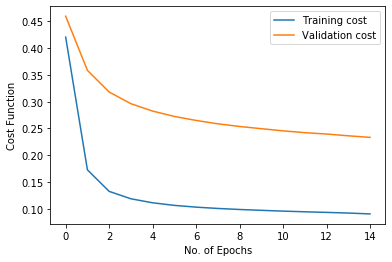

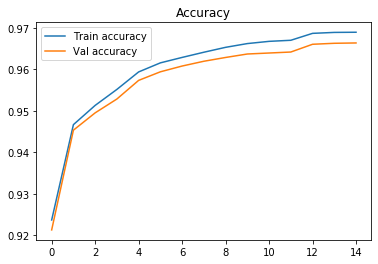

In [ ]:
# plot the results
plt.plot(train_costs, label='Training cost')
plt.plot(validation_costs, label='Validation cost')
plt.title('')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost Function')
plt.legend()
plt.savefig("model1-trainval.png", dpi=300)
plt.show()

plt.plot(train_accuracies, label='Train accuracy')
plt.plot(validation_accuracies, label='Val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_report1 = my_score(model1, Xtest_PCA, Ytest) 
test_cost1 = get_cost(model1, criterion1, Xtest_PCA, Ytest)
print(test_report1)

              precision    recall  f1-score   support

      Normal       0.63      0.92      0.75      9711
      Attack       0.91      0.59      0.72     12833

    accuracy                           0.73     22544
   macro avg       0.77      0.76      0.73     22544
weighted avg       0.79      0.73      0.73     22544



In [ ]:
order = 2 # The second 30 features will be keeped
hidden_size = 20
model2 = NeuralNet(input_size, hidden_size, num_classes, remove_percentage, order)


# Loss and optimizer
criterion2 = torch.nn.BCELoss()
optimizer2 = torch.optim.Rprop(model2.parameters(), lr = 3e-2)

# Use a DataLoader to manage batches
bs = data_size # batch size
train_ds = TensorDataset(Xtrain_PCA, Ytrain)
valid_ds = TensorDataset(Xval_PCA, Yval)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# things to keep track of
train_costs2 = []
validation_costs2 = []
train_accuracies2 = []
validation_accuracies2 = []

print("Training the second neural network...")

# main training loop
for i in range(num_epochs):
    cost = 0
    val_cost = 0
    for xb,yb in train_dl:
        cost += train(model2, criterion2, optimizer2, xb, yb)
        
    train_acc = get_accuracy(model2, Xtrain_PCA, Ytrain)
    val_acc = get_accuracy(model2, Xval_PCA, Yval) 
    val_cost = get_cost(model2, criterion2, Xval_PCA, Yval)
    
    test_acc = get_accuracy(model2, Xtest_PCA, Ytest)

    print("Epoch: %d, val_cost: %f, val_acc: %.4f, test_acc: %.4f" % (i, val_cost, val_acc, test_acc))
    
    # for plotting
    train_costs2.append(cost / len(train_dl))
    train_accuracies2.append(train_acc)
    validation_costs2.append(val_cost)
    validation_accuracies2.append(val_acc)

print("Training is done")

Training the second neural network...
Epoch: 0, val_cost: 0.676735, val_acc: 0.6882, test_acc: 0.5707
Epoch: 1, val_cost: 0.653340, val_acc: 0.7059, test_acc: 0.6450
Epoch: 2, val_cost: 0.632073, val_acc: 0.7143, test_acc: 0.6762
Epoch: 3, val_cost: 0.609567, val_acc: 0.7403, test_acc: 0.6641
Epoch: 4, val_cost: 0.590167, val_acc: 0.7373, test_acc: 0.6847
Epoch: 5, val_cost: 0.571238, val_acc: 0.6300, test_acc: 0.5763
Epoch: 6, val_cost: 0.553349, val_acc: 0.6484, test_acc: 0.6164
Epoch: 7, val_cost: 0.540250, val_acc: 0.7080, test_acc: 0.6414
Epoch: 8, val_cost: 0.520787, val_acc: 0.7196, test_acc: 0.6400
Epoch: 9, val_cost: 0.504287, val_acc: 0.7099, test_acc: 0.6404
Epoch: 10, val_cost: 0.502979, val_acc: 0.7195, test_acc: 0.5958
Epoch: 11, val_cost: 0.469917, val_acc: 0.8143, test_acc: 0.6862
Epoch: 12, val_cost: 0.468464, val_acc: 0.7774, test_acc: 0.6544
Epoch: 13, val_cost: 0.456732, val_acc: 0.8232, test_acc: 0.6842
Epoch: 14, val_cost: 0.452915, val_acc: 0.8215, test_acc: 0.67

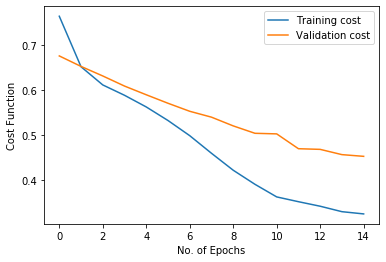

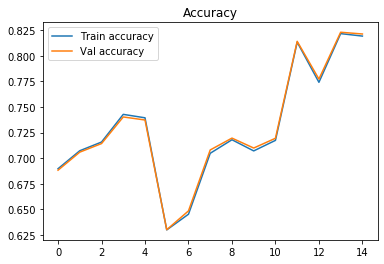

In [ ]:
# plot the results
plt.plot(train_costs2, label='Training cost')
plt.plot(validation_costs2, label='Validation cost')
plt.title('')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost Function')
plt.legend()
plt.savefig("model2-trainval.png", dpi=300)
plt.show()

plt.plot(train_accuracies2, label='Train accuracy')
plt.plot(validation_accuracies2, label='Val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_report2 = my_score(model2, Xtest_PCA, Ytest) 
test_cost2 = get_cost(model2, criterion2, Xtest_PCA, Ytest)
print(test_report2)

              precision    recall  f1-score   support

      Normal       0.58      0.88      0.70      9711
      Attack       0.85      0.51      0.64     12833

    accuracy                           0.67     22544
   macro avg       0.72      0.70      0.67     22544
weighted avg       0.74      0.67      0.67     22544



TUning the third neural network

In [ ]:
order = 3 # The third 30 features will be keeped
hidden_size = 15
model3 = NeuralNet(input_size, hidden_size, num_classes, remove_percentage, order)

# Loss and optimizer
criterion3 = torch.nn.BCELoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 1e-4, amsgrad=True)

#######################################################################################

# Use a DataLoader to manage batches
bs = 512 # batch size
train_ds = TensorDataset(Xtrain_PCA, Ytrain)
valid_ds = TensorDataset(Xval_PCA, Yval)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# things to keep track of
train_costs3 = []
validation_costs3 = []
train_accuracies3 = []
validation_accuracies3 = []

print("Training the third neural network...")

# main training loop
for i in range(num_epochs): # Number of epochs
    cost = 0
    val_cost = 0
    for xb,yb in train_dl:
        cost += train(model3, criterion3, optimizer3, xb, yb)
        
    train_acc = get_accuracy(model3, Xtrain_PCA, Ytrain)
    val_acc = get_accuracy(model3, Xval_PCA, Yval) 
    val_cost = get_cost(model3, criterion3, Xval_PCA, Yval)
    
    test_acc = get_accuracy(model3, Xtest_PCA, Ytest)

    print("Epoch: %d, val_cost: %f, val_acc: %.4f, test_acc: %.4f" % (i, val_cost, val_acc, test_acc))
    
    # for plotting
    train_costs3.append(cost / len(train_dl))
    train_accuracies3.append(train_acc)
    validation_costs3.append(val_cost)
    validation_accuracies3.append(val_acc)

print("Training is done")

Training the third neural network...
Epoch: 0, val_cost: 0.713280, val_acc: 0.3673, test_acc: 0.3978
Epoch: 1, val_cost: 0.706774, val_acc: 0.4340, test_acc: 0.4783
Epoch: 2, val_cost: 0.700262, val_acc: 0.5996, test_acc: 0.6500
Epoch: 3, val_cost: 0.694460, val_acc: 0.6128, test_acc: 0.6882
Epoch: 4, val_cost: 0.688195, val_acc: 0.6239, test_acc: 0.6934
Epoch: 5, val_cost: 0.681391, val_acc: 0.6418, test_acc: 0.7019
Epoch: 6, val_cost: 0.674184, val_acc: 0.7029, test_acc: 0.7234
Epoch: 7, val_cost: 0.666579, val_acc: 0.7553, test_acc: 0.7197
Epoch: 8, val_cost: 0.658595, val_acc: 0.7659, test_acc: 0.7213
Epoch: 9, val_cost: 0.650764, val_acc: 0.7679, test_acc: 0.7201
Epoch: 10, val_cost: 0.642786, val_acc: 0.7718, test_acc: 0.7208
Epoch: 11, val_cost: 0.635287, val_acc: 0.7698, test_acc: 0.7189
Epoch: 12, val_cost: 0.628263, val_acc: 0.7711, test_acc: 0.7167
Epoch: 13, val_cost: 0.621607, val_acc: 0.7712, test_acc: 0.7143
Epoch: 14, val_cost: 0.615616, val_acc: 0.7708, test_acc: 0.714

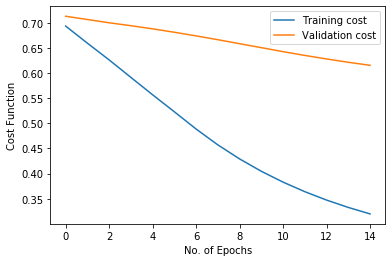

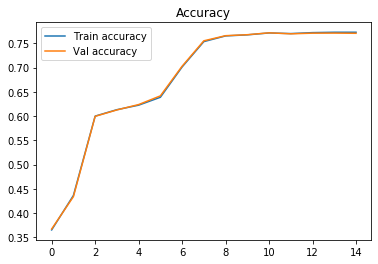

In [ ]:
# plot the results
plt.plot(train_costs3, label='Training cost')
plt.plot(validation_costs3, label='Validation cost')
plt.title('')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost Function')
plt.legend()
plt.savefig("model3-trainval.png", dpi=300)
plt.show()

plt.plot(train_accuracies3, label='Train accuracy')
plt.plot(validation_accuracies3, label='Val accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_report3 = my_score(model3, Xtest_PCA, Ytest) 
test_cost3 = get_cost(model3, criterion3, Xtest_PCA, Ytest)
print(test_report3)

              precision    recall  f1-score   support

      Normal       0.61      0.95      0.74      9711
      Attack       0.94      0.54      0.68     12833

    accuracy                           0.71     22544
   macro avg       0.77      0.74      0.71     22544
weighted avg       0.79      0.71      0.71     22544



# Voting Systems

In [ ]:
def fct (input1, input2, input3):
    # Sort the predictions p
    votes = [input1, input2, input3]
    votes.sort()
    return (1 / 2) * ( votes[0] * ( 1 - weight(votes[1]) ) + votes[1] + weight(votes[1]) * votes[2] )

def weight (r):
    if r < 0.4:
        return 0
    elif r>=0.4 and r<= 0.6:
        return (5 * r - 2)
    else:
        return 1

In [ ]:
def simple_voting(inputs, labels):
    
    # Computre predictions
    prediction1 = model1(inputs)
    prediction2 = model2(inputs)
    prediction3 = model3(inputs)
    
    # Apply the average function on the predictions
    fused = np.empty(prediction1.detach().numpy().shape)
    for i in range(len(labels)):
        fused [i] = fct (round(prediction1.detach().numpy()[i][0], 4), round(prediction2.detach().numpy()[i][0], 4), round(prediction3.detach().numpy()[i][0], 4))
        
    fused_label = (fused > 0.5)
    
    return (accuracy_score(labels, fused_label), fused)


Compute the correlation between different predictions

In [ ]:
from scipy.stats import pearsonr

prediction1 = model1(Xtest_PCA)
prediction2 = model2(Xtest_PCA)
prediction3 = model3(Xtest_PCA)
A = []
B = []
C = []
for i in range(len(prediction3.detach().numpy())):
    A.append(round(prediction1.detach().numpy()[i][0], 4))
    B.append(round(prediction2.detach().numpy()[i][0], 4))
    C.append(round(prediction3.detach().numpy()[i][0], 4))

print("The correlation between NN1 and NN2: ", pearsonr(A, B), "NN2 and NN3: ", pearsonr(C, B), "NN1 and NN3: ", pearsonr(A, C))

The correlation between NN1 and NN2:  (0.47816483936747717, 0.0) NN2 and NN3:  (0.13553194773035193, 6.945814183634415e-93) NN1 and NN3:  (0.5495374298132389, 0.0)


Now we will test out models

In [ ]:
#Print all accuracies

test_acc = get_accuracy(model1, Xtest_PCA, Ytest)
test_acc2 = get_accuracy(model2, Xtest_PCA, Ytest)
test_acc3 = get_accuracy(model3, Xtest_PCA, Ytest)

finale_accuracy, fused = simple_voting(Xtest_PCA, Ytest)
print("Accuracy of NN1: %.4f. Accuracy of NN2: %.4f. Accuracy of NN3: %.4f. And final accuracy is: %.4f" % (test_acc, test_acc2, test_acc3, finale_accuracy))

Accuracy of NN1: 0.7332. Accuracy of NN2: 0.6735. Accuracy of NN3: 0.7148. And final accuracy is: 0.7362


In [ ]:
# Print the classification report of the majority function
 fused_label = (fused > 0.5)
print(classification_report(Ytest, fused_label, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.63      0.93      0.75      9711
      Attack       0.92      0.59      0.72     12833

    accuracy                           0.74     22544
   macro avg       0.78      0.76      0.73     22544
weighted avg       0.80      0.74      0.73     22544



In [ ]:
value = (prediction1 + prediction2 + prediction3)/3
value = (value > 0.5)
print(accuracy_score(Ytest, value))

0.7523509581263307


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision score: {}".format(precision_score(Ytest, fused_label)))
print("Precision score: {}".format(f1_score(Ytest, fused_label)))
print("Recall score: {}".format(recall_score(Ytest, fused_label)))

Precision score: 0.9194589984159863
Precision score: 0.7173003802281369
Recall score: 0.5880152731239773


### Reputation module

In [ ]:
 from operator import add
 
 def review(inputs, labels):
    Reliability = [0, 0, 0]

    # Computre predictions
    prediction1 = model1(inputs)
    prediction2 = model2(inputs)
    prediction3 = model3(inputs)

    _, fused_predictions = simple_voting(inputs, labels)
    for i in range(len(labels)):
      if labels.detach().numpy()[i][0] != fused_predictions[i]:
        votes = [round(prediction1.detach().numpy()[i][0], 4), round(prediction2.detach().numpy()[i][0], 4), round(prediction3.detach().numpy()[i][0], 4)]
        votes.sort()
        if votes[1]>=0.4 and votes[1]<= 0.6:
          Reliability =  list(map(add, Reliability, give_reliability(votes, labels.detach().numpy()[i][0])))
    return Reliability

def give_reliability(L, labels):
  R0 = 0
  R1 = 0
  R2 = 0
  L= [(b>0.5) for b in L]

  if L[0] == labels:
    if (L[1] == labels and L[2] != labels) or (L[2] == labels and L[1] != labels):
      R0 = 1
    elif L[1] != labels and L[2] != labels:
      R0 = 2
  if L[1] == labels:
    if (L[0] == labels and L[2] != labels)  or (L[2] == labels and L[0] != labels):
      R1 = 1
    elif L[0] != labels and L[2] != labels:
      R1 = 2
  if L[2] == labels:
    if (L[0] == labels and L[1] != labels)  or (L[1] == labels and L[0] != labels):
      R2 = 1
    elif L[0] != labels and L[1] != labels:
      R2 = 2
  return (R0, R1, R2)

In [ ]:
# Now we will test the model according the reputation

def voting_reputation(inputs_train, labels_train, inputs, labels):
  Reputations = review(inputs_train, labels_train)
  _, fused_predictions = simple_voting(inputs, labels)

  # Compute predictions
  prediction1 = model1(inputs)
  prediction2 = model2(inputs)
  prediction3 = model3(inputs)

  for i in range(len(labels)):
    votes = [round(prediction1.detach().numpy()[i][0], 4), round(prediction2.detach().numpy()[i][0], 4), round(prediction3.detach().numpy()[i][0], 4)]
    votes.sort()
    if votes[1]>=0.4 and votes[1]<= 0.6:
      fused_predictions[i][0] = votes[Reputations.index(max(Reputations))]

  fused_predictions = (fused_predictions > 0.49 )
  return (accuracy_score(labels, fused_predictions), fused_predictions)

In [ ]:
new_fused, fused_reputation = voting_reputation(Xtrain_PCA, Ytrain, Xtest_PCA, Ytest)

print("Accuracy of NN1: %.4f. Accuracy of NN2: %.4f. Accuracy of NN3: %.4f. And final accuracy is: %.4f. New reputation based accuracy %.4f" 
      % (test_acc, test_acc2, test_acc3, finale_accuracy, new_fused))

Accuracy of NN1: 0.7332. Accuracy of NN2: 0.6735. Accuracy of NN3: 0.7148. And final accuracy is: 0.7362. New reputation based accuracy 0.7654


In [ ]:
# Print the classification report of the majority function with liability 
print(classification_report(Ytest, fused_reputation, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.67      0.90      0.77      9711
      Attack       0.90      0.67      0.76     12833

    accuracy                           0.77     22544
   macro avg       0.78      0.78      0.77     22544
weighted avg       0.80      0.77      0.77     22544



## Hard Voting

In [ ]:
def majority_vote(inputs, labels):
    
    # Computre predictions
    prediction1 = predict(model1, inputs)
    prediction2 = predict(model2, inputs)
    prediction3 = predict(model3, inputs)
    voter = np.empty(prediction1.detach().numpy().shape)
    
    for i in range(len(labels)):
      voter [i] = counter (int(prediction1.detach().numpy()[i][0]), int(prediction2.detach().numpy()[i][0]), 
                           int(prediction3.detach().numpy()[i][0]))
        
    return (accuracy_score(labels, voter), voter)



def counter (a, b, c):
  tmp = (a + b + c)
  if tmp == 3 or tmp == 2:
    return True
  else: 
    return False


In [ ]:
score_hard, voter_hard = majority_vote(Xtest_PCA, Ytest) 
print("Accuracy of NN1: %.4f. Accuracy of NN2: %.4f. Accuracy of NN3: %.4f. And final accuracy is: %.4f" % (test_acc, test_acc2, test_acc3, score_hard))

Accuracy of NN1: 0.7332. Accuracy of NN2: 0.6735. Accuracy of NN3: 0.7148. And final accuracy is: 0.7316


In [ ]:
# Print the classification report of the hard voting approach 
print(classification_report(Ytest, voter_hard, target_names=['Normal', 'Attack']))

              precision    recall  f1-score   support

      Normal       0.63      0.93      0.75      9711
      Attack       0.92      0.58      0.71     12833

    accuracy                           0.73     22544
   macro avg       0.77      0.76      0.73     22544
weighted avg       0.79      0.73      0.73     22544



## Weighted Average

In [ ]:
def weighted(train_inputs, train_labels, test_inputs, test_labels):
  model1.eval()
  model2.eval()
  model3.eval()

  tain_prediction1 = model1.forward(train_inputs)
  tain_prediction2 = model2.forward(train_inputs)
  tain_prediction3 = model3.forward(train_inputs)

  train_data = np.concatenate((tain_prediction1.detach().numpy(), tain_prediction2.detach().numpy(), tain_prediction3.detach().numpy()), axis=1)
  
  test_prediction1 = model1.forward(test_inputs)
  test_prediction2 = model2.forward(test_inputs)
  test_prediction3 = model3.forward(test_inputs)

  test_data = np.concatenate((test_prediction1.detach().numpy(), test_prediction2.detach().numpy(), test_prediction3.detach().numpy()), axis=1)
  test_data = (test_data > 0.5)
  
  batch_s = 128
  
  Xtrain_combined = torch.from_numpy(train_data).float()

  train_ds = TensorDataset(Xtrain_combined, train_labels)
  train_dl = DataLoader(train_ds, batch_size=batch_s, shuffle=True)

  output_size = 1
  learning_rate = 0.001

  # Build a feed-forward network
  sofmtax_layer = torch.nn.Sequential(torch.nn.Linear(3, output_size), torch.nn.Sigmoid())

  # Loss and optimizer
  sofmtax_criterion = torch.nn.MSELoss()
  sofmtax_optimizer = torch.optim.Adam(sofmtax_layer.parameters(), lr=learning_rate)

  # main training loop
  print("Training..")
  for i in range(num_epochs): # Number of epochs
    cost = 0
    for xb, yb in train_dl: 
      # Forward pass
      outputs = sofmtax_layer(xb)
      loss = sofmtax_criterion(outputs, yb)
      
      # Backward and optimize
      sofmtax_optimizer.zero_grad()
      loss.backward()
      sofmtax_optimizer.step() 
  print("Testing..")
  
  Xtest_combined = torch.from_numpy(test_data).float()

  final_prediction = sofmtax_layer(Xtest_combined)
  final_prediction = (final_prediction > 0.5)
  report = classification_report(test_labels, final_prediction.detach().numpy(), target_names=['Normal', 'Attack'])
  print("Classification report of the weighted layer: ")
  return report 

In [ ]:
print(weighted(Xtrain_PCA, Ytrain, Xtest_PCA, Ytest))

Training..
Testing..
Classification report of the weighted layer: 
              precision    recall  f1-score   support

      Normal       0.63      0.92      0.75      9711
      Attack       0.91      0.59      0.72     12833

    accuracy                           0.73     22544
   macro avg       0.77      0.76      0.73     22544
weighted avg       0.79      0.73      0.73     22544



## MoE Layer

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions.normal import Normal
import numpy as np

In [ ]:
class SparseDispatcher(object):
    """Helper for implementing a mixture of experts.
    The purpose of this class is to create input minibatches for the
    experts and to combine the results of the experts to form a unified
    output tensor.
    There are two functions:
    dispatch - take an input Tensor and create input Tensors for each expert.
    combine - take output Tensors from each expert and form a combined output
      Tensor.  Outputs from different experts for the same batch element are
      summed together, weighted by the provided "gates".
    The class is initialized with a "gates" Tensor, which specifies which
    batch elements go to which experts, and the weights to use when combining
    the outputs.  Batch element b is sent to expert e iff gates[b, e] != 0.
    The inputs and outputs are all two-dimensional [batch, depth].
    Caller is responsible for collapsing additional dimensions prior to
    calling this class and reshaping the output to the original shape.
    See common_layers.reshape_like().
    Example use:
    gates: a float32 `Tensor` with shape `[batch_size, num_experts]`
    inputs: a float32 `Tensor` with shape `[batch_size, input_size]`
    experts: a list of length `num_experts` containing sub-networks.
    dispatcher = SparseDispatcher(num_experts, gates)
    expert_inputs = dispatcher.dispatch(inputs)
    expert_outputs = [experts[i](expert_inputs[i]) for i in range(num_experts)]
    outputs = dispatcher.combine(expert_outputs)
    The preceding code sets the output for a particular example b to:
    output[b] = Sum_i(gates[b, i] * experts[i](inputs[b]))
    This class takes advantage of sparsity in the gate matrix by including in the
    `Tensor`s for expert i only the batch elements for which `gates[b, i] > 0`.
    """

    def __init__(self, num_experts, gates):
        """Create a SparseDispatcher."""

        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        # drop indices
        _, self._expert_index = sorted_experts.split(1, dim=1)
        # get according batch index for each expert
        self._batch_index = sorted_experts[index_sorted_experts[:, 1],0]
        # calculate num samples that each expert gets
        self._part_sizes = list((gates > 0).sum(0).numpy())
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)

    def dispatch(self, inp):
        """Create one input Tensor for each expert.
        The `Tensor` for a expert `i` contains the slices of `inp` corresponding
        to the batch elements `b` where `gates[b, i] > 0`.
        Args:
          inp: a `Tensor` of shape "[batch_size, <extra_input_dims>]`
        Returns:
          a list of `num_experts` `Tensor`s with shapes
            `[expert_batch_size_i, <extra_input_dims>]`.
        """

        # assigns samples to experts whose gate is nonzero

        # expand according to batch index so we can just split by _part_sizes
        inp_exp = inp[self._batch_index].squeeze(1)
        return torch.split(inp_exp, self._part_sizes, dim=0)


    def combine(self, expert_out, multiply_by_gates=True):
        """Sum together the expert output, weighted by the gates.
        The slice corresponding to a particular batch element `b` is computed
        as the sum over all experts `i` of the expert output, weighted by the
        corresponding gate values.  If `multiply_by_gates` is set to False, the
        gate values are ignored.
        Args:
          expert_out: a list of `num_experts` `Tensor`s, each with shape
            `[expert_batch_size_i, <extra_output_dims>]`.
          multiply_by_gates: a boolean
        Returns:
          a `Tensor` with shape `[batch_size, <extra_output_dims>]`.
        """
        # apply exp to expert outputs, so we are not longer in log space
        stitched = torch.cat(expert_out, 0).exp()

        if multiply_by_gates:
            stitched = stitched.mul(self._nonzero_gates)
        zeros = torch.zeros(self._gates.size(0), expert_out[-1].size(1), requires_grad=True)
        # combine samples that have been processed by the same k experts
        combined = zeros.index_add(0, self._batch_index, stitched.float())
        # add eps to all zero values in order to avoid nans when going back to log space
        combined[combined == 0] = np.finfo(float).eps
        # back to log space
        return combined.log()


    def expert_to_gates(self):
        """Gate values corresponding to the examples in the per-expert `Tensor`s.
        Returns:
          a list of `num_experts` one-dimensional `Tensor`s with type `tf.float32`
              and shapes `[expert_batch_size_i]`
        """
        # split nonzero gates for each expert
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)




class MoE(nn.Module):

    """Call a Sparsely gated mixture of experts layer with 1-layer Feed-Forward networks as experts.
    Args:
    input_size: integer - size of the input
    output_size: integer - size of the input
    num_experts: an integer - number of experts
    hidden_size: an integer - hidden size of the experts
    noisy_gating: a boolean
    k: an integer - how many experts to use for each batch element
    """

    def __init__(self, input_size, output_size, num_experts, hidden_size, noisy_gating=True, k=4):
        super(MoE, self).__init__()
        self.noisy_gating = noisy_gating
        self.num_experts = num_experts
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k = k
        # instantiate experts
        self.experts = nn.ModuleList([model1, model2, model3])
        # Keep the pre-trained state
        #for m in [model1, model2, model3]:
         # for p in m.parameters():
          #  p.requires_grad=False
        self.w_gate = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)
        self.w_noise = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)

        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(1)
        self.normal = Normal(torch.tensor([0.0]), torch.tensor([1.0]))

        assert(self.k <= self.num_experts)

    def cv_squared(self, x):
        """The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        Args:
        x: a `Tensor`.
        Returns:
        a `Scalar`.
        """
        eps = 1e-10
        # if only num_experts = 1
        if x.shape[0] == 1:
            return torch.Tensor([0])
        return x.float().var() / (x.float().mean() + eps)


    def _gates_to_load(self, gates):
        """Compute the true load per expert, given the gates.
        The load is the number of examples for which the corresponding gate is >0.
        Args:
        gates: a `Tensor` of shape [batch_size, n]
        Returns:
        a float32 `Tensor` of shape [n]
        """
        return (gates > 0).sum(0)




    def _prob_in_top_k(self, clean_values, noisy_values, noise_stddev, noisy_top_values):
        """Helper function to NoisyTopKGating.
        Computes the probability that value is in top k, given different random noise.
        This gives us a way of backpropagating from a loss that balances the number
        of times each expert is in the top k experts per example.
        In the case of no noise, pass in None for noise_stddev, and the result will
        not be differentiable.
        Args:
        clean_values: a `Tensor` of shape [batch, n].
        noisy_values: a `Tensor` of shape [batch, n].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, n], or None
        noisy_top_values: a `Tensor` of shape [batch, m].
           "values" Output of tf.top_k(noisy_top_values, m).  m >= k+1
        Returns:
        a `Tensor` of shape [batch, n].
        """

        batch = clean_values.size(0)
        m = noisy_top_values.size(1)
        top_values_flat = noisy_top_values.flatten()
        threshold_positions_if_in = torch.arange(batch) * m + self.k
        threshold_if_in = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_in), 1)
        is_in = torch.gt(noisy_values, threshold_if_in)
        threshold_positions_if_out = threshold_positions_if_in - 1
        threshold_if_out = torch.unsqueeze(torch.gather(top_values_flat,0 , threshold_positions_if_out), 1)
        # is each value currently in the top k.
        prob_if_in = self.normal.cdf((clean_values - threshold_if_in)/noise_stddev)
        prob_if_out = self.normal.cdf((clean_values - threshold_if_out)/noise_stddev)
        prob = torch.where(is_in, prob_if_in, prob_if_out)
        return prob


    def noisy_top_k_gating(self, x, train, noise_epsilon=1e-2):
        """Noisy top-k gating.
          See paper: https://arxiv.org/abs/1701.06538.
          Args:
            x: input Tensor with shape [batch_size, input_size]
            train: a boolean - we only add noise at training time.
            noise_epsilon: a float
          Returns:
            gates: a Tensor with shape [batch_size, num_experts]
            load: a Tensor with shape [num_experts]
        """
        clean_logits = x @ self.w_gate
        if self.noisy_gating:
            raw_noise_stddev = x @ self.w_noise
            noise_stddev = ((self.softplus(raw_noise_stddev) + noise_epsilon) * train)
            noisy_logits = clean_logits + ( torch.randn_like(clean_logits) * noise_stddev)
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        top_logits, top_indices = logits.topk(min(self.k + 1, self.num_experts), dim=1)
        top_k_logits = top_logits[:, :self.k]
        top_k_indices = top_indices[:, :self.k]
        top_k_gates = self.softmax(top_k_logits)

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts:
            load = (self._prob_in_top_k(clean_logits, noisy_logits, noise_stddev, top_logits)).sum(0)
        else:
            load = self._gates_to_load(gates)
        return gates, load



    def forward(self, x, train=True, loss_coef=1e-2):
        """Args:
        x: tensor shape [batch_size, input_size]
        train: a boolean scalar.
        loss_coef: a scalar - multiplier on load-balancing losses

        Returns:
        y: a tensor with shape [batch_size, output_size].
        extra_training_loss: a scalar.  This should be added into the overall
        training loss of the model.  The backpropagation of this loss
        encourages all experts to be approximately equally used across a batch.
        """
        gates, load = self.noisy_top_k_gating(x, train)
        # calculate importance loss
        importance = gates.sum(0)
        #
        loss = self.cv_squared(importance) + self.cv_squared(load)
        loss *= loss_coef

        dispatcher = SparseDispatcher(self.num_experts, gates)
        expert_inputs = dispatcher.dispatch(x)
        gates = dispatcher.expert_to_gates()
        ## Try to use train and eval modes
        if train:
            for i in range(self.num_experts):
                self.experts[i].train()
                expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        else:
            for i in range(self.num_experts):
                self.experts[i].train()
                expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        y = dispatcher.combine(expert_outputs)
        return y, loss


In [ ]:
def MoE_train(x,y, model, loss_fn, optim):
    # model returns the prediction and the loss that encourages all experts to have equal importance and load
    y_hat, aux_loss = model(x.float())
    # calculate prediction loss
    loss = loss_fn(y_hat, y)
    # combine losses
    total_loss = loss + aux_loss
    optim.zero_grad()
    total_loss.backward()
    optim.step()

    print("Training Results - loss: {:.2f}, aux_loss: {:.3f}".format(loss.item(), aux_loss.item()))
    return model

def eval(x, y, model, loss_fn):
    model.eval()
    # model returns the prediction and the loss that encourages all experts to have equal importance and load
    y_hat, aux_loss = model(x.float(), train=False)
    loss = loss_fn(y_hat, y)
    total_loss = loss + aux_loss
    print("Evaluation Results - loss: {:.2f}, aux_loss: {:.3f}".format(loss.item(), aux_loss.item()))
    y_hat = (y_hat > 0.5)
    accuracy_score(y, y_hat)
    print("accuracy is ", accuracy_score(y, y_hat))
    print("Report: ")
    print(classification_report(y, y_hat, target_names=['Normal', 'Attack']))


In [ ]:

# convert the data arrays into torch tensors
Xtrain_PCA = torch.from_numpy(X_train_PCA).float()
Ytrain = torch.from_numpy(Y_train2.to_numpy()).float()

Xval_PCA = torch.from_numpy(X_val_PCA).float()
Yval = torch.from_numpy(Y_val2.to_numpy()).float()

Xtest_PCA = torch.from_numpy(X_test_PCA).float()
Ytest = torch.from_numpy(Y_test2.to_numpy()).float()

# arguments
num_classes = 1
num_experts = 3
hidden_size = 64
k = 2

# instantiate the MoE layer
model = MoE(input_size, num_classes, num_experts,hidden_size, k=k, noisy_gating=True)

loss_fn = nn.BCEWithLogitsLoss()
optim = Adam(model.parameters())

num_epochs = 15
# train
model = MoE_train(Xtrain_PCA, Ytrain, model, loss_fn, optim)
# evaluate
eval(Xtest_PCA, Ytest, model, loss_fn)





Training Results - loss: 0.58, aux_loss: 0.003
Evaluation Results - loss: 0.58, aux_loss: 14.475
accuracy is  0.783667494677076
Report: 
              precision    recall  f1-score   support

      Normal       0.69      0.90      0.78      9711
      Attack       0.90      0.69      0.79     12833

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.81      0.78      0.78     22544

